# DMV Analysis and predictions

In [44]:
import pandas as pd #general manipulation
import numpy as np #general manipulation
import os # to import models
from datetime import datetime, timedelta
import pickle #loads model
import ipywidgets as widgets #intercative model selection
import constants #local file containing information about the dataset
import matplotlib.pyplot as plt

## Intro
#### Motivation
The DMV is an entity that provides essential services such as providing/renewing driver’s licenses and IDs.

During the 2020 pandemic the NJ DMV stopped accepting walk-ins and all visits needed to be booked online ahead of time. Since the system transitioned to be online only, frequently there are no available appointments for the following 90 days and one needs to keep trying to schedule an appointment.
The model developed for this project aims to help people to schedule their appointments by providing them a better window of time to go online and book the service they need. 

This is a personal project, one that started when I tried to renew my driver's license and couldn't because there wasn't available times.

The NJ MVC Appointment Scheduling can be found <a href="https://telegov.njportal.com/njmvc/AppointmentWizard">here</a>.

## Project structure
This project is split in three main parts: 
* data collection;
* data manipulation and model training, and
* project description and model deployment. 

The reason for this division is that having the data collection as its own file allows it to be run in parallel and that havig the model deployment segregated allows is to run without the dataset present.

## Data collection
The project starts by scrapping the DMV website using Python and Selenium to get the next appointment available for all locations for all services at a given time and storing them in a SQL database. This data collection was being executed every approximately two minutes, a balance between not stressing the website, having too many duplicate entries and data granularity. This scrip run on Raspberry Pi in parallel to any analysis and was executed for a few months.

## Manipulation steps

### Data structure
Each service has a list of all locations, even if a given location didn't offer that specific service during the data collection time window. 
Each location for each service had its very next available appointment collected every approximately two minutes, and if no available appointment existed, it was completed with a NULL.

### Extracting data structure
The sqlite_schema was used to retrieve all services, as each one is a table in the database. From the tables, all columns names were retrieved to get all location names.

### Cleaning NULLS
A SQL query was executed to replace the words NULLs with the actual NULL values.

### Retrieving the right time
The shift (am/pm) information was lost during the scrapping data, hence they needed to be reintroduced to the SQL. Some rules were applied to find the missing information, like repeated hours for the same day are always in the afternoon and the first hour after a new day are in the morning.

### Removing locations that don't have any appointment
Not all locations provide all services, and the ones without any entry were removed from that service. They could also be removed because during the time the data was collected no new appointment was created. No model can be trained without data, so their removal is necessary in either case.

### Dealing with missing data
The data contains certain periods of time missing, either because the website or the scrapping script were down. The script will will find the next available appointment for each entry and calculate how much time it takes until it; if an appointment is available, this distance is zero.
Just before a gap in measurement, the distance will either be zero (appointment available) or it will calculate the distance in hours until the next appointment. This can introduce an outlier depending of the time elapsed without data collection and to avoid it a fake appointment was created as last value before a gap. This also introduces an error, but it is less variable than an unknown gap.

Finally, a fake event is created as the very last entry of each location beacuse the data will later be "stacked" and all columns will be merged. This step is to prevent leaking information between locations, because the next available appointment would be located in the next location.

The dataset at this point in the cleaning is presented below. Is was saved that step and retrieved here:

In [35]:
service_df = pd.read_pickle('INITIAL_PERMIT_df_raw') #read dataframe after cleaning
service_df[155:159]# note how two appointments become available in Eatontown only between 10/24/21 1:17pm and 10/24/21 1:19pm

,time_shift,Bakers_Basin,Bayonne,Camden,Cardiff,Delanco,Eatontown,Edison,Elizabeth,Flemington,...,Oakland,Paterson,Rahway,Randolph,Rio_Grande,Salem,Toms_River,Vineland,Wayne,West_Deptford
155,2021-10-24 13:14:00,None,None,None,12/23/2021 08:15 AM,12/23/2021 09:45 AM,None,None,None,None,...,None,None,None,None,12/18/2021 12:15 PM,12/23/2021 08:15 AM,None,12/23/2021 08:45 AM,None,12/23/2021 08:15 AM
156,2021-10-24 13:17:00,None,None,None,12/23/2021 08:15 AM,12/23/2021 09:45 AM,12/21/2021 02:15 PM,None,None,None,...,None,None,None,None,12/22/2021 12:45 PM,12/23/2021 08:15 AM,None,12/23/2021 08:45 AM,None,12/23/2021 08:15 AM
157,2021-10-24 13:19:00,None,None,None,12/23/2021 08:15 AM,10/25/2021 02:45 PM,12/21/2021 02:15 PM,None,None,None,...,None,None,None,None,12/22/2021 12:45 PM,12/23/2021 08:15 AM,None,12/23/2021 08:45 AM,None,12/23/2021 08:15 AM
158,2021-10-24 13:21:00,None,None,None,12/23/2021 08:15 AM,12/22/2021 09:45 AM,None,None,None,None,...,None,None,None,None,12/23/2021 08:15 AM,12/23/2021 08:15 AM,None,12/23/2021 08:45 AM,None,12/23/2021 08:15 AM


Using the cleaned data, we can observe how hard is to schedule an appointment by just going to the website at any given time. Below is the percentage that certain location will have an appointment, for any given time.

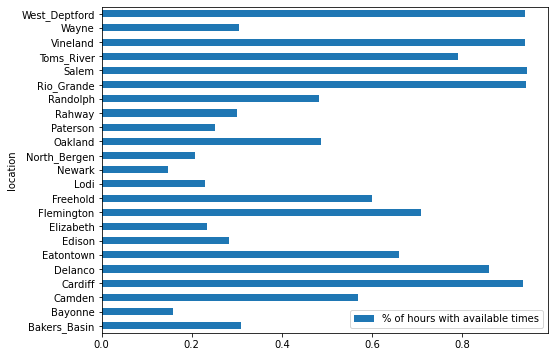

In [45]:
availability = pd.melt(service_df, id_vars=['time_shift'], value_vars=service_df.columns[1:], var_name = 'location') # melts df
availability['n of hours with available times'] = availability['value'].apply(lambda x: 0 if x is None else 1) # 1 if that time is available for that service, 0 if not
availability['% of hours with available times'] = availability['n of hours with available times']/(len(availability)/len(availability.location.unique())) # same, nut in % for sum
availability_per_location = availability.groupby('location').sum() #uses groupby to isolate percentage by location and sum them to get % not idle
availability_per_location = pd.DataFrame(availability_per_location.to_records()) #flattens index for plotting
ax = availability_per_location.plot.barh(x='location', y='% of hours with available times', rot=0, figsize=(8, 6)) #horizintal bar plot for clarity

This shows that certain locations like West Deptford or Vineland have planty of times, opposed to Newark or Bayonne where one would have less than 20% of chance of being able to schedule a new driver's license in the first try.

Manipulation – continuation
### Stacking by melting
it was decided to stack all columns together and have one column with all the next appointments and one with the location labels instead of one column per 
location to make it easier to apply functions to calculate functions of interest, like distance between next appointments and counts.

### Calculating the next appointment
A countdown of lines was calculated for each value that returns when the next appointmnet is going to take place. If it exists for that time, the difference is zero. This countdown is used to get the next appointmnet and finally the time it will take for the appointment to become available. ***This will be the value to be predicted by the model***. At this point all columns that will not be used were dropped.

### Checking for FFT (tentative)
Fast Fourier Transform was applied for checking if any frequency of appointments occured in the data and if it could be used for predicting the next appointments. The results were inconclusive and the method was aborted.

### Adding categorical values for dates
Finally, the weekdays, hours and minutes were transformed into categorical columns for appling the final model. This data will be loaded in the next cell:

In [2]:
service_df_cleaned = pd.read_pickle('INITIAL_PERMIT_df_cleaned') #read dataframe after cleaning
service_df_cleaned.head() #note that day is the weekday

,time_shift,location,diffOfTime_vertical,days_cat,hours_cat,minutes_cat
0,2021-10-23 10:12:00,Bakers_Basin,0 days 13:59:00,5,10,12
1,2021-10-23 10:14:00,Bakers_Basin,0 days 13:57:00,5,10,14
2,2021-10-23 10:16:00,Bakers_Basin,0 days 13:55:00,5,10,16
3,2021-10-23 10:18:00,Bakers_Basin,0 days 13:53:00,5,10,18
4,2021-10-23 10:21:00,Bakers_Basin,0 days 13:50:00,5,10,21


Below is how long one must wait before the service is available and they can scheduled any appointment.

Note the gap in data colection when the line is not vertical. 

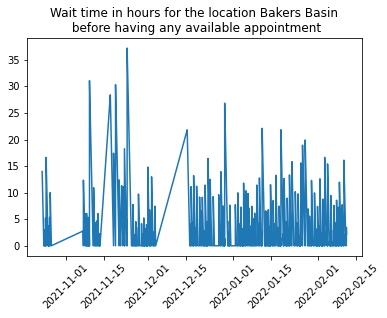

In [22]:
plt.plot(service_df_cleaned.time_shift[:53007], service_df_cleaned.diffOfTime_vertical[:53007]/np.timedelta64(1, 'h'))
plt.title('Wait time in hours for the location Bakers Basin\n before having any available appointment')
plt.xticks(rotation=45)
plt.show()
#plt.draw()

## Model construction

### Parameters
Finally, the model was built by using the categorical time columns and predicting when the next appointment would be available. 

Days, hours and minutes were one hot encoded to serve as input. Two main kinds of categorical transformation for days were possible: day of the month and weekday. Weekdays returned better results, which indicates knowing how far in the week one is when trying to schedule an appointment is more usefull than having the day of the month information available.

### Construction
A custom class and factory were built for the model:
- The factory contained the instructions for one hot encoding and a blank model with pre-determined hyperparameters in a form of a pipeline.
- The class received the cleaned data from the earlier steps, split it by location and called the factory. As it dynamically called new blank models, each one was independent from each other, which was used to predict different services and locations.

The idea is to apply the model 

### Hyperparameters
Once the model was ready, a GridSearchCV was run on several sets of hyperparameters and the one with best score was chosen. In order to use the GridSearchCV the dataset was split by location and the one hot encoder transformation was manually applied.

### Evaluation
As a timeseries has time as dependent variable, the dataset was split into the first 80% and the last 20% of observations, to avoid data leakage from the future to present.

The scope of this project is to make one model for all services and locations, hence the evaluation was made on one location at a time.



## Model deployment

### Final choice
After optimizing the model with random forest regressor and ridge, the Root Mean Square Error (RMSE) was calculated for each one. The ridge model had an error as small as the random forest, with the advantage of being faster and easier to explain and faster

In [38]:
service_dropdown = widgets.Dropdown(
    options=constants.services, #services stored in a file called constants
    value='INITIAL_PERMIT',
    description='Service:',
    disabled=False,
)
location_dropdown = widgets.Dropdown(
    options=constants.locations, #locations stored in a file called constants
    value='Bakers_Basin',
    description='Location:',
    disabled=False,
)

display(service_dropdown)
display(location_dropdown)

Dropdown(description='Service:', index=1, options=('CDL_PERMIT_OR_ENDORSEMENT', 'INITIAL_PERMIT', 'KNOWLEDGE_T…

Dropdown(description='Location:', options=('Bakers_Basin', 'Bayonne', 'Camden', 'Cherry_Hill', 'Cardiff', 'Del…

Loads models

In [47]:
model_name = service_dropdown.value + '_' + location_dropdown.value + '_model' # 
try:
    model = pickle.load(open((os.path.join('models', model_name)), 'rb'))
    now = datetime.today() #prediction will be based on current time
    df_predict = pd.DataFrame({'days_cat': [now.weekday()], 'hours_cat':[now.hour], 'minutes_cat':[now.minute]}) #now.weekday()
    [results] = model.predict(df_predict) / 3.6e+12 #nano seconds to hours
    predicted_time = now + timedelta(hours = results)
    print('The best time to try to schedule an appointment is: '\
        + predicted_time.strftime('%x, %I:%m %p'))
except FileNotFoundError:
    model = 'no_model'
    print('no model exists for that combination. Does ' + location_dropdown.value + ' provide ' + service_dropdown.value + '?')

The best time to try to schedule an appointment is: 05/30/22, 10:05 PM


## Conclusion

This model was able to predict a better time for returning to the website and scheduling an appointment online for a given location. The services offered by them are often vital and this tool aims to help people by providing them a better chance to use these services.

The dataset was collected during the period of five months and there is room for improvement; the data is still being collected and can be used to improve the model.

The final model used was a linear one, as it provided an error as low as a more complex models. It has the advantage of having a higher explainability and a smaller training time.

*Cesar Krischer, 2022*